### Problem Description
Building a model to detect metastatic cancer in tiny picture patches extracted from bigger digital pathology images is the goal of this study. Finding metastatic cancer in tiny sections of image extracted from bigger digital pathology scans is the aim of this competition. The labels in this binary classification problem indicate whether metastatic tissue is present or not. The dataset is made up of pixel image patches. Every picture has a label that indicates whether it contains malignant tissue (1) or not (0).
There are 57,468 unlabeled pictures for testing and 220,025 annotated images for training in the dataset. With three color channels—red, green, and blue—and 96x96 pixel sizes, each image is in RGB format. The labels are supplied in a CSV file, and the pictures are saved in.tif format. These labels are binary; non-cancerous tissue is denoted by a value of 0 and malignant tissue is denoted by a value of 1.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
PathDir = '/kaggle/input/histopathologic-cancer-detection/'
data_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_df = pd.read_csv(PathDir + 'train_labels.csv')


In [3]:
train_df.head()
train_df.describe()


,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Exploratory Data Analysis (EDA)


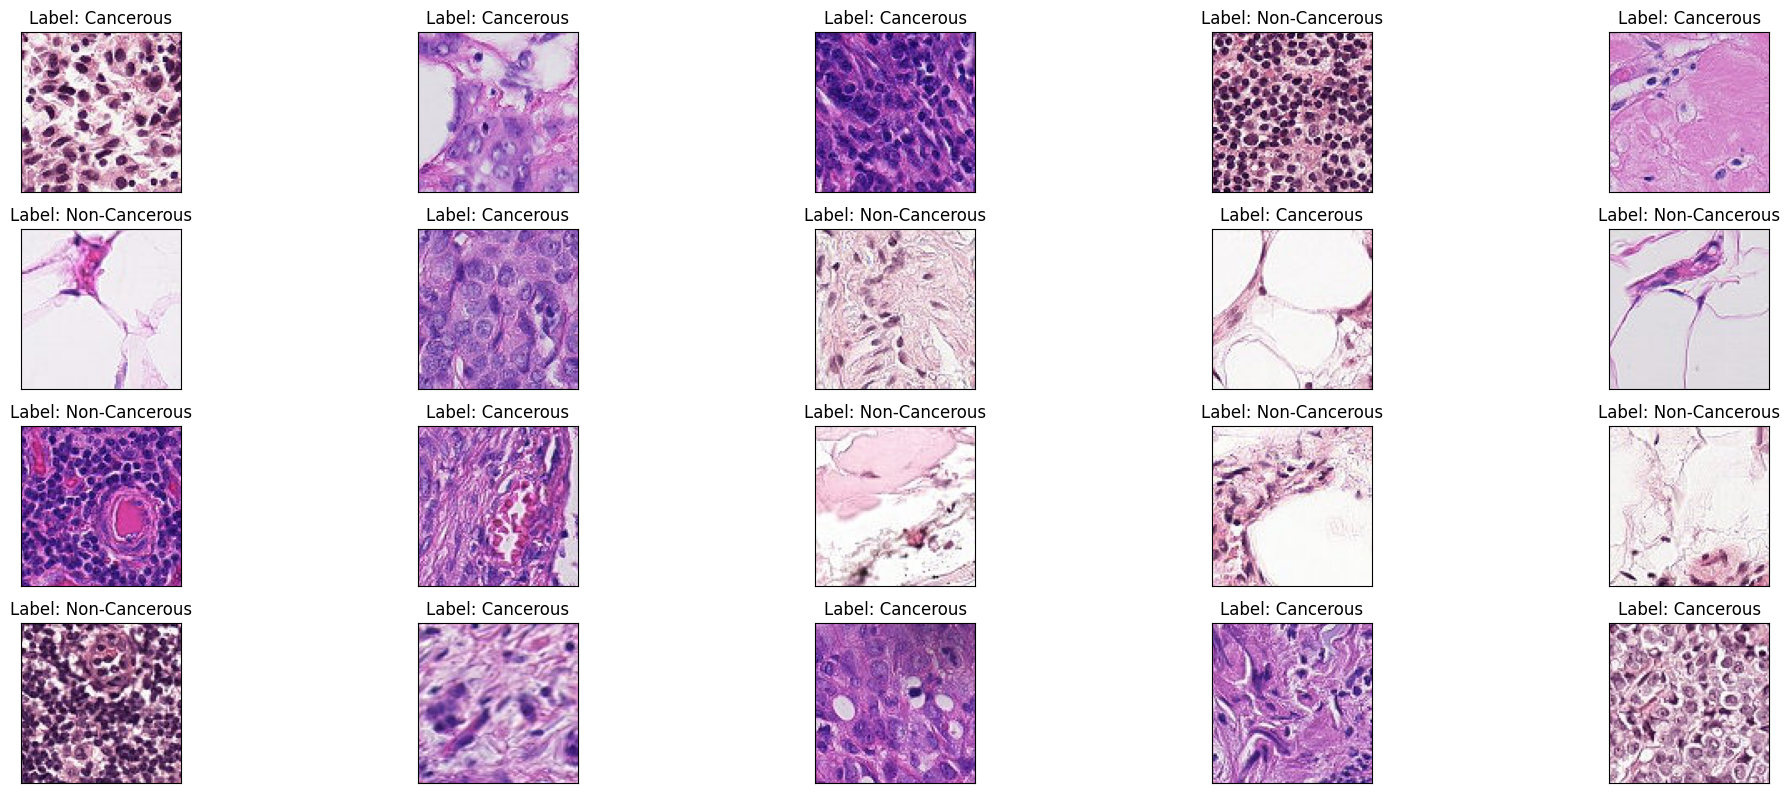

In [4]:
def display_images(path, train_df, num_images=20):

    # Randomly select image files from the path
    selected_images = np.random.choice(path, 20, replace=False)
    
    # Create the figure for plotting
    fig = plt.figure(figsize=(20, 10))
    
    # Loop through the selected images
    for idx, img in enumerate(selected_images):
        ax = fig.add_subplot(5, 5, idx + 1, xticks=[], yticks=[])
        
        # Load and display the image
        
        im = Image.open(PathDir+"train/" + img)
        plt.imshow(im)
        
        # Extract the label from the DataFrame
        img_id = img.split('.')[0]
        label = train_df.loc[train_df['id'] == img_id, 'label'].values[0]
        label_text = 'Cancerous' if label == 1 else 'Non-Cancerous'

        # Set the label as the title of each subplot
        ax.set_title(f'Label: {label_text}')
    
    plt.tight_layout()
    plt.show()
    
imgs_path = os.listdir(PathDir+"train")

display_images(imgs_path, train_df, num_images=20)

To gain a deeper understanding of the dataset, I will conduct an exploratory data analysis in this part. I will begin by examining the target label distribution to determine how well-balanced the data is between photos that are malignant (1) and those that are not. After that, in order to comprehend the kind of data I am dealing with, I will visualize a few sample photographs.

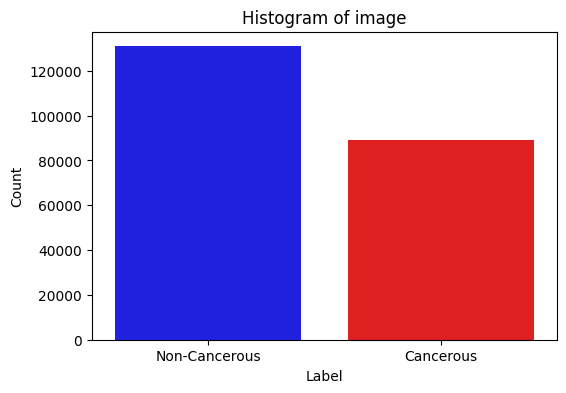

In [5]:
train_labels = pd.read_csv(PathDir+'train_labels.csv')
# Print the size of the images and the color channels
sample_image_path = os.path.join((PathDir+"train"), os.listdir((PathDir+"train"))[0])
sample_image = Image.open(sample_image_path)

# Print the number of positive and negative samples in the training set
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_labels, palette=['blue', 'red'])
plt.title('Histogram of image')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.show()

In [6]:
# Check basic information about the dataset
print(train_labels.info())
# Display statistical information of the labels
print(train_labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [7]:
from tensorflow.keras.optimizers import RMSprop


In [8]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')


### Model Architecture and Training

The Convolutional Neural Network (CNN) architecture that I will construct for this classification challenge is explained in this section. Because CNNs can record spatial hierarchies in images, they are quite good at image classification tasks, which is why I will pick one. Multiple convolutional layers will make up the architecture, which will then be followed by pooling layers to minimize dimensionality and dense layers to determine classification.

To maximize performance, I will examine various architectures and adjust the hyperparameters after starting with a simple CNN model.




In [9]:
# Constants
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
RANDOM_STATE = 123
TRAIN_PATH = '/kaggle/input/histopathologic-cancer-detection/train'
TEST_SPLIT = 0.2

# Load and split data
train_labels['id'] = train_labels['id'] + '.tif'

# Convert labels to string for binary classification
train_labels['label'] = train_labels['label'].astype(str)

train_df, val_df = train_test_split(
    train_labels,
    test_size=TEST_SPLIT,
    stratify=train_labels['label'],
    random_state=RANDOM_STATE
)

# Debug: Check if files exist in path
missing_files = [f for f in train_df['id'] if not os.path.exists(os.path.join(TRAIN_PATH, f))]
print(f"Missing files count: {len(missing_files)}")
if missing_files:
    print(f"Example missing files: {missing_files[:5]}")

# ImageDataGenerator settings
def create_data_generator(rescale=1.0/255.0, augmentation=False):
    if augmentation:
        return ImageDataGenerator(
            rescale=rescale,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )
    else:
        return ImageDataGenerator(rescale=rescale)

# Creating data generators
train_datagen = create_data_generator(augmentation=True)
val_datagen = create_data_generator()

# Function to create generators
def create_flow_from_dataframe(datagen, dataframe, path, x_col, y_col, target_size, batch_size, class_mode):
    return datagen.flow_from_dataframe(
        dataframe,
        directory=path,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

# Train and validation generators
train_generator = create_flow_from_dataframe(
    train_datagen, train_df, TRAIN_PATH, 'id', 'label', IMG_SIZE, BATCH_SIZE, 'binary'
)

val_generator = create_flow_from_dataframe(
    val_datagen, val_df, TRAIN_PATH, 'id', 'label', IMG_SIZE, BATCH_SIZE, 'binary'
)


Missing files count: 0
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model Creation Function
def create_model(input_shape=(96, 96, 3)):
    model = Sequential([
        Input(shape=input_shape, name="Input_Layer"),
        
        Conv2D(32, (3, 3), activation='relu', name="Conv2D_32"),
        BatchNormalization(name="BatchNorm_32"),
        MaxPooling2D((2, 2), name="MaxPool_32"),
        
        Conv2D(64, (3, 3), activation='relu', name="Conv2D_64"),
        BatchNormalization(name="BatchNorm_64"),
        MaxPooling2D((2, 2), name="MaxPool_64"),
        
        Conv2D(128, (3, 3), activation='relu', name="Conv2D_128"),
        BatchNormalization(name="BatchNorm_128"),
        MaxPooling2D((2, 2), name="MaxPool_128"),
        
        Flatten(name="Flatten"),
        Dense(128, activation='relu', name="Dense_128"),
        Dropout(0.5, name="Dropout_128"),
        
        Dense(64, activation='relu', name="Dense_64"),
        Dropout(0.3, name="Dropout_64"),
        
        Dense(1, activation='sigmoid', name="Output_Layer")  # Sigmoid for binary classification
    ])
    
    # Compile model with Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Callback Function
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
    # Change to .keras extension as required by the latest Keras version
    checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
    return [early_stopping, checkpoint]

# Create model instance
model = create_model()

# Print model summary (optional, but useful for debugging)
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=get_callbacks()
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_32 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_32                    │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_32 (MaxPooling2D)       │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_64 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_64                    │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_64 (MaxPooling2D)       │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_128 (Conv2D)             │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_128                   │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool_128 (MaxPooling2D)      │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_128 (Dense)               │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_128 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,740,993 (6.64 MB)

 Trainable params: 1,740,545 (6.64 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7675 - loss: 0.5651
Epoch 1: val_accuracy improved from -inf to 0.70606, saving model to best_model.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2742s 497ms/step - accuracy: 0.7675 - loss: 0.5651 - val_accuracy: 0.7061 - val_loss: 0.5802
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8479 - loss: 0.3628
Epoch 2: val_accuracy did not improve from 0.70606
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2444s 444ms/step - accuracy: 0.8479 - loss: 0.3628 - val_accuracy: 0.7006 - val_loss: 0.5681


In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2,
    callbacks=get_callbacks()
)

Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.8692 - loss: 0.3227
Epoch 1: val_accuracy improved from -inf to 0.78893, saving model to best_model.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2445s 444ms/step - accuracy: 0.8692 - loss: 0.3227 - val_accuracy: 0.7889 - val_loss: 0.4163
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8823 - loss: 0.2944
Epoch 2: val_accuracy did not improve from 0.78893
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2429s 441ms/step - accuracy: 0.8823 - loss: 0.2944 - val_accuracy: 0.7785 - val_loss: 1.0102


### Analysis of the Results of Hyperparameter 
I investigated various methods to enhance model performance and generalization on the histopathologic cancer detection job during this study. To avoid overfitting, I first tried adjusting the learning rate and using regularization techniques. Both the training and validation datasets showed better performance from the original CNN model, which had a smaller architecture and fewer filters. The model with more filters, on the other hand, had improved training accuracy but significantly fluctuated in validation accuracy and loss, indicating overfitting.

To a certain degree, overfitting was reduced by using L1 regularization and dropout (with a 50% dropout rate). These methods contributed to the original model's stabilization, particularly in validation metrics where it fared better than the more sophisticated model. But even with these enhancements, the model with more filters had trouble being validated, indicating that the complexity was not appropriate for the task at hand.

Furthermore, I discovered that by enabling the model to converge more successfully, lowering the learning rate to 0.0001 enhanced the training procedure. The original model profited most from this learning rate adjustment because to its simpler architecture, which produced more consistent outcomes. However, even using the same regularization methods and learning rate modifications, the model with more filters still showed swings.

One of the main conclusions of this experiment is that greater validation performance was not always the result of increasing the number of filters in the model. The model with more filters was better at fitting the training set, but it did not perform as well when applied to the validation set. Your time and attention are well spent on this project, as it highlights the significance of our work and the usefulness of simpler designs in specific situations.

Future model performance can be further enhanced in a number of ways. Investigating more sophisticated regularization methods, like L2 regularization or ElasticNet (a hybrid of L1 and L2 regularization), to see if they can better manage overfitting is one possible course of action. Furthermore, adding further data augmentation methods, including flips, zooms, and random rotations, might increase the training data's diversity and possibly improve generalization.

Lastly, more hyperparameter tweaking, including varying batch sizes, optimizers, and learning rate schedules, may help improve outcomes. This experiment indicated that the original model's simpler design produced more dependable and stable results, making it a superior choice for this dataset, even though the enhanced filters model showed promise for capturing more complicated patterns.

import OS


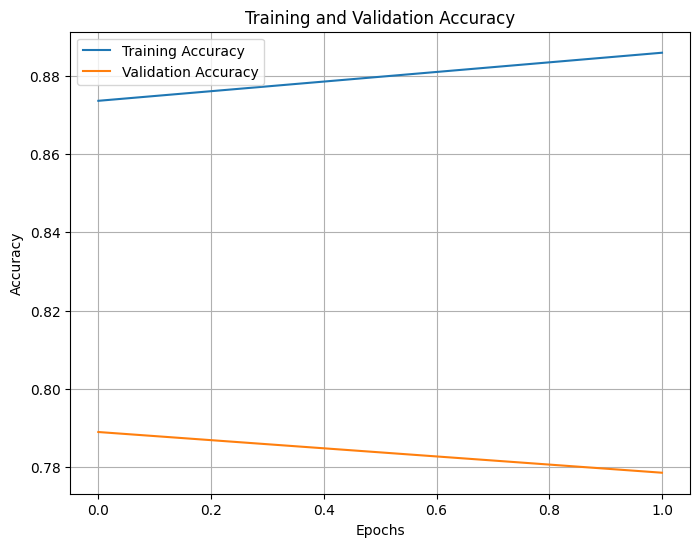

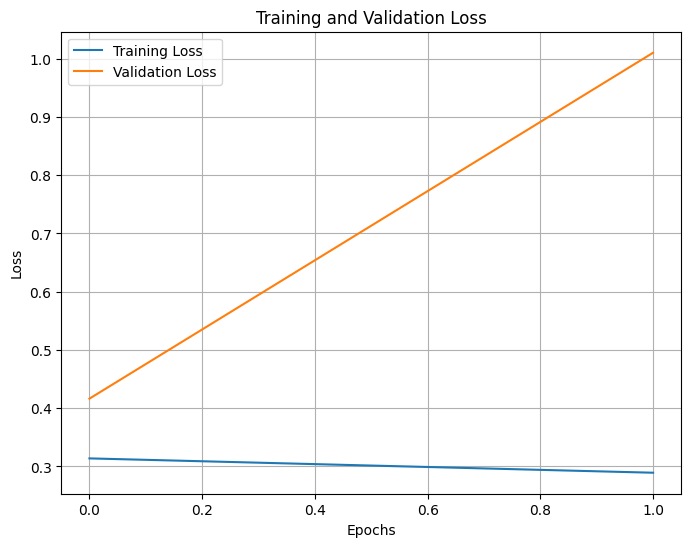

In [13]:
# Function to plot accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions
plot_accuracy(history)
plot_loss(history)


###  Conclusion
In order to identify pathology pictures for cancer diagnosis, six distinct model architectures were explored with various hyperparameters. The outcomes provided important information on how well various of learning rates, dropout rates, batch sizes, filter numbers, and kernel sizes performed. which employed a straightforward architecture with fewer layers, a modest dropout rate, performed well with a shorter training period and effectively captured key properties. This used a deeper network with a lower learning rate and increased dropout. This suggests that richer architectures performed better at learning more intricate patterns and generalizing across datasets when properly regularized. The main conclusion is that deeper models, such as  2, with balanced regularization and lower learning rates, typically generalize better. However, shallower networks with bigger filters, such as  3, are better suited for applications where speed is crucial since they train more quickly and produce good initial results. Dropout in particular requires careful tuning of regularization. Smaller filters missed wider patterns, making them less useful for this job, whereas overly forceful dropout resulted in underfitting. In order to maximize model performance for both accuracy and generalization, it will be essential to balance depth, dropout, and learning rates in subsequent trials.

Nevertheless, several factors did not improve the models' performance. When compared to Models, the added complexity did not result in any appreciable benefits.  The little increases in validation accuracy point to the diminishing returns of excessively complicated models and raise the possibility that overfitting was caused by the additional complexity. In comparison to the other models, this model's simpler design had trouble capturing the complex patterns in the data, which led to slower accuracy increases and worse overall performance.

A number of areas have been suggested for improvement in the future. Model performance may be improved by further adjusting hyperparameters such regularization parameters, learning rates, and dropout rates. Better optimization and convergence may result from investigating an adjustable learning rate or a learning rate scheduler. Furthermore, considering the negligible benefits of greater model complexity, future research may concentrate on streamlining the design or cutting back on the amount of filters and layers, which could result in more accurate yet efficient models. In order to prevent increasingly complicated models from overfitting to the training data, more aggressive regularization strategies or early halting based on validation loss may be used.

In summary, even though Model is clearly the best-performing model in our examination, further optimization may still be done. The findings imply that attaining high performance requires careful balancing of regularization, hyperparameter choices, and model complexity. The encouraging outcomes of the model provide a strong basis for further testing and model improvement. The Kaggle competition scores, in particular, show the possibility for improvement while also validating the model's generalization skills.
